---

# Setup

##### Set Root Dir as CWD

In [6]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

##### Imports

In [7]:
import pickle

import numpy as np
import pandas as pd

import spacy

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [8]:
path = "data/yelp/reviews/"

In [9]:
%%time
# Load dev set (10% of total data) as train
all_data = pd.read_pickle(path + "train.xz")

CPU times: total: 29.3 s
Wall time: 29.5 s


In [10]:
train, _ = train_test_split(all_data, train_size=300_000, stratify=all_data["stars"])
train, test = train_test_split(train, test_size=50_000, stratify=train["stars"])

In [11]:
train

,text,stars
6370909,Seriously the best burger I have had in years!...,5
937738,Kevin and his wife did a great job for my mom ...,5
278441,There is something truly heartbreaking and sub...,4
187118,Slid into Slate last evening after work for a ...,3
3510999,This is not like Stockton Market or Hopewell B...,5
...,...,...
1468833,We enjoyed excellent food and service at Comma...,5
373882,We have used this place only since being in Tu...,5
2657507,"beware, not honest. horrible experience. almos...",1
353577,The experience was great. Everyone was very fr...,5


In [12]:
test

,text,stars
48956,I got the fried chicken that was on the menu i...,3
3861034,"I was trying not to do this, but my throbbing ...",2
2427095,We originally visited Cristino's searching for...,5
1748274,The pizza was frozen kind. Place was empty 4-5...,2
2056256,Super cute place. I walked in and the woman ma...,4
...,...,...
1619305,Eh...typical marina fair. Serves the purpose i...,3
470123,Go somewhere else if you like Mexican food. Ch...,2
5571044,5/5 hands down. This restaurant was my favorit...,5
3959816,Looks can be deceiving with this place. It's ...,5


##### Save Target

In [13]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [14]:
batch_size = 4000
n_processes = 4

vocab_size = 20_000  # Size of vocabulary
maxlen = 200         # Number of words per review to consider

In [15]:
# Configure preprocessor based on prev experiment
prep = ReviewPreprocessor(vocab_size, maxlen, remove_stop=False, remove_punc=False, lemmatize=False)

X_train = prep.fit_transform(train["text"], batch_size, n_processes)
X_test = prep.transform(test["text"], batch_size, n_processes)

# Define Model

In [16]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer

In [17]:
def create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout):
    model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), 
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Define Configurations

In [18]:
configs = { 
    #        reg  drop
    "none": (0.0, 0.0),
    "low":  (1.0e-3, 0.1),
    "med":  (1.0e-2, 0.25),
    "high": (5.0e-2, 0.5),
}

# Run Experiment

> Tests and saves results for each preprocessing configuration.

In [ ]:
%%time
epochs = 10

results = dict()
for config, params in configs.items():
    model = create_model(maxlen, vocab_size, embed_dim, num_heads, ff_dims, *params)
    
    results[config] = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
                                validation_data=(X_test, y_test), verbose=1)
    
# Save results
final_results = {cfg: hist.history for cfg, hist in results.items()}
with open('experiments/results/reg_results.pickle', 'wb') as handle:
    pickle.dump(final_results, handle)

Epoch 1/10
7813/7813 [==============================] - 41s 5ms/step - loss: 0.7849 - accuracy: 0.6726 - val_loss: 0.7468 - val_accuracy: 0.6862
Epoch 2/10
7813/7813 [==============================] - 43s 6ms/step - loss: 0.7143 - accuracy: 0.6995 - val_loss: 0.7422 - val_accuracy: 0.6910
Epoch 3/10
7813/7813 [==============================] - 36s 5ms/step - loss: 0.6869 - accuracy: 0.7115 - val_loss: 0.7505 - val_accuracy: 0.6876
Epoch 4/10
7813/7813 [==============================] - 37s 5ms/step - loss: 0.6649 - accuracy: 0.7207 - val_loss: 0.7729 - val_accuracy: 0.6830
Epoch 5/10
7813/7813 [==============================] - 36s 5ms/step - loss: 0.6450 - accuracy: 0.7282 - val_loss: 0.7930 - val_accuracy: 0.6821
Epoch 6/10
7813/7813 [==============================] - 36s 5ms/step - loss: 0.6249 - accuracy: 0.7374 - val_loss: 0.8108 - val_accuracy: 0.6805
Epoch 7/10
7813/7813 [==============================] - 35s 5ms/step - loss: 0.6037 - accuracy: 0.7461 - val_loss: 0.8166 - val_ac

# Viz

##### Load?

In [ ]:
with open('experiments/results/reg_results.pickle', 'rb') as handle:
    final_results = pickle.load(handle)

In [18]:
final_results

{'none': {'loss': [0.7928962111473083,
   0.7175706624984741,
   0.6899109482765198,
   0.6674190163612366,
   0.6479158401489258,
   0.6270806193351746,
   0.6082817316055298,
   0.5891371369361877,
   0.5723675489425659,
   0.5559813976287842],
  'accuracy': [0.6689199805259705,
   0.6984480023384094,
   0.7101200222969055,
   0.7198399901390076,
   0.7273480296134949,
   0.7378039956092834,
   0.746288001537323,
   0.7551760077476501,
   0.761788010597229,
   0.7702760100364685],
  'val_loss': [0.7527366280555725,
   0.744102954864502,
   0.7472820281982422,
   0.7679600715637207,
   0.771781861782074,
   0.7953081130981445,
   0.819179356098175,
   0.8667758107185364,
   0.894984245300293,
   0.9345840811729431],
  'val_accuracy': [0.6867799758911133,
   0.6906800270080566,
   0.690060019493103,
   0.6847800016403198,
   0.6809999942779541,
   0.6789199709892273,
   0.6755599975585938,
   0.6745200157165527,
   0.6714199781417847,
   0.6631199717521667]},
 'low': {'loss': [0.829143

##### Viz

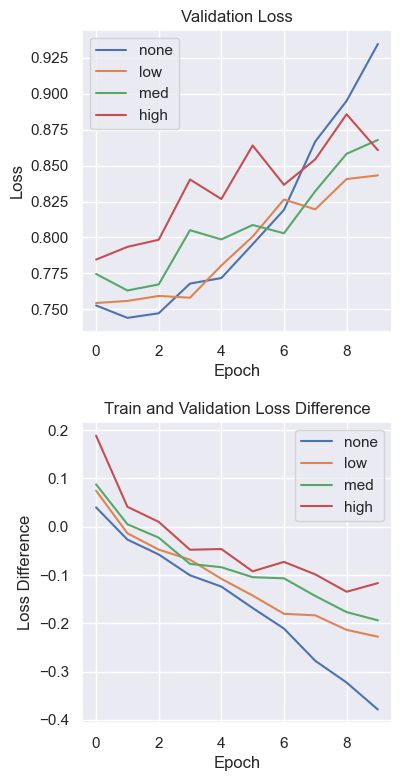

In [34]:
fig, axes = plt.subplots(2, 1, dpi=100, figsize=(4, 9))



for cfg, hist in final_results.items():
    axes[0].plot(hist["val_loss"], label=cfg)
    
axes[0].set_title("Regularization Loss Comparison")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

for cfg, hist in final_results.items():
    axes[1].plot(hist["val_acc"], label=cfg)
    
axes[1].set_title("Regularization Accuracy Comparison")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Difference")
axes[1].legend()

plt.subplots_adjust(hspace=0.3)

plt.show()